In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from decimal import Decimal

In [2]:
Node = 1000
m = 2
times = 100
M_list = [4, 8, 10, 20]
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
w_list = [Decimal("0.00"), Decimal("0.50"), Decimal("0.70"), Decimal("0.90"), Decimal("0.95"), Decimal("0.98")]

3つの異なるネットワーク構造における、モジュラリティ-ネットワーク直径の関係図

In [3]:
for M in M_list:
    for beta in beta_list:
        records = []
        for W in w_list:
            for i in tqdm(range(times)):
                g = gt.load_graph(f"~/o_t_hayashilab/network_data/graph-tool/modular_network/N={Node}/m={m}/beta={beta}/w={W}/Mo={M}/{i}.gt.gz")
                # 最大連結成分で計算
                l = gt.label_largest_component(g)
                u = gt.GraphView(g, vfilt=l)
                # 直径
                diam = gt.pseudo_diameter(u)[0]
                # モジュラリティ
                state = gt.BlockState(g, b=g.vp.module_number)
                Q = gt.modularity(g, state.get_blocks())
                records.append({"modularity": Q, "diameter": diam, "w": float(W), "beta": beta})
        # DataFrame化してcsv保存
        df = pd.DataFrame(records)
        df.to_csv(f"~/o_t_hayashilab/network_code/result/mo{M}_beta{beta}_modularity_vs_diameter.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 283.69it/s]


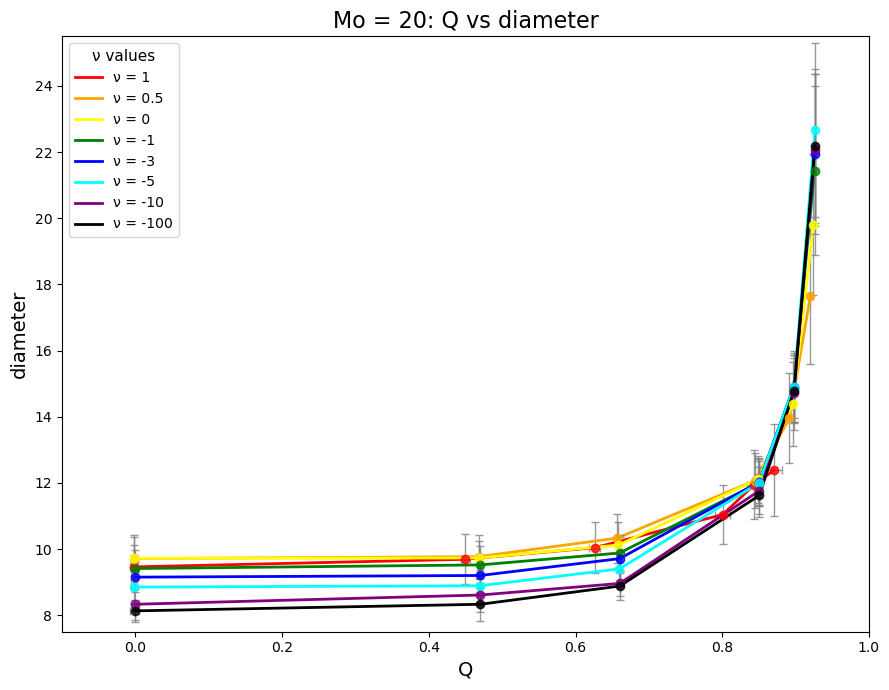

In [6]:
color_list = [
    "red",       # β = 1
    "orange",    # β = 0.5
    "yellow",    # β = 0
    "green",     # β = -1
    "blue",      # β = -3
    "cyan",      # β = -5
    "purple",    # β = -10
    "black",     # β = -100
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# betaのリストと色の固定対応
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
color_list = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", "black"]
color_map = dict(zip(beta_list, color_list))

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]
Mo = 20

plt.figure(figsize=(9, 7))

for beta in beta_list:
    df = pd.read_csv(f"~/o_t_hayashilab/network_code/result/mo{Mo}_beta{beta}_modularity_vs_diameter.csv")
    df = df[df["w"].isin(w_list)]

    # 平均・標準偏差の取得
    means = df.groupby("w").agg({"modularity": "mean", "diameter": "mean"})
    stds = df.groupby("w").agg({"modularity": "std", "diameter": "std"})

    for w in w_list:
        sub = df[df["w"] == w]
        mean_mod = sub["modularity"].mean()
        mean_fied = sub["diameter"].mean()
        std_mod = sub["modularity"].std()
        std_fied = sub["diameter"].std()
        plt.errorbar(mean_mod, mean_fied, xerr=std_mod, yerr=std_fied,
                     fmt='o', color=color_map[beta], ecolor="gray", elinewidth=1, capsize=3, alpha=0.8)

    # トレンド線
    plt.plot(means["modularity"], means["diameter"], '-', linewidth=2,
             color=color_map[beta], label=f"ν = {beta}")

# 軸・タイトル・凡例など
plt.xlabel("Q", fontsize=14)
plt.ylabel("diameter", fontsize=14)
plt.title(f"Mo = {Mo}: Q vs diameter", fontsize=16)
plt.xlim(-0.1, 1.0)
plt.ylim(7.5, 25.5)
plt.legend(title="ν values", fontsize=10, title_fontsize=11, loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()
